In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [3]:
# taxa de juros de mercado
RISK_FREE_RATE = 0.05
# consideraremos os retornos mensais - e queremos calcular o retorno anual
MONTHS_IN_YEAR = 12

## Download dos dados

In [5]:
start_date = '2010-01-01'
end_date = '2017-01-01'
data = {}
stocks = ['IBM', '^GSPC']

for stock in stocks:
    ticker = yf.download(stock, start_date, end_date)
    # utilizar o Adj Close é melhor nesse caso, pois leva em consideração o preço após ajustes para todas as divisões e distribuições de dividendos aplicáveis.
    data[stock] = ticker['Adj Close']
stock_data = pd.DataFrame(data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
stock_data

,IBM,^GSPC
Date,,
2010-01-04,85.347488,1132.989990
2010-01-05,84.316475,1136.520020
2010-01-06,83.768784,1137.140015
2010-01-07,83.478806,1141.689941
2010-01-08,84.316475,1144.979980
...,...,...
2016-12-23,126.714783,2263.790039
2016-12-27,127.041634,2268.879883
2016-12-28,126.319550,2249.919922


## Processamento dos dados

In [9]:
# usamos retornos mensais em vez de retornos diários
# retornos diários são superiores para previsões de curto prazo
# para modelos de longo prazo, os retornos mensais são favoráveis. os retornos de dados mensais são pelo menos aproximadamente distribuídos normalmente
# stock e market returns (IBM e SAP 500)

stock_data = stock_data.resample('M').last()
        
        
data = pd.DataFrame({'s_adjclose': stock_data[stocks[0]],
                         'm_adjclose': stock_data[stocks[1]]})

# logarithmic monthly returns
data[['s_returns', 'm_returns']] = np.log(data[['s_adjclose', 'm_adjclose']] / data[['s_adjclose', 'm_adjclose']].shift(1))

# remove the NaN values
data = data[1:]
data

,s_adjclose,m_adjclose,s_returns,m_returns
Date,,,,
2010-02-28,82.305222,1104.489990,0.042696,0.028115
2010-03-31,83.010727,1169.430054,0.008535,0.057133
2010-04-30,83.496201,1186.689941,0.005831,0.014651
2010-05-31,81.491028,1089.410034,-0.024308,-0.085532
2010-06-30,80.333023,1030.709961,-0.014312,-0.055388
...,...,...,...,...
2016-08-31,119.677544,2170.949951,-0.002293,-0.001220
2016-09-30,119.654922,2168.270020,-0.000189,-0.001235
2016-10-31,115.768173,2126.149902,-0.033022,-0.019617


## Cálculo do beta através da covariância

In [10]:
# matriz de covariância: os itens diagonais são as variâncias
# fora da diagonal são as covariâncias
# a matrix é simétrica: cov[0 1] = cov[1,0]

covariance_matrix = np.cov(data['s_returns'], data['m_returns'])
# beta = cov(ra,rm)/var(rm)
beta = covariance_matrix[0,1] / covariance_matrix[1,1]
print('Beta from the formula', beta)

Beta from the formula 0.7135091486609736


## Cálculo do beta através da regressão

In [13]:
# usando regressão linear para ajustar uma linha aos dados
# [stock_returns, market_returns] - inclinação é o beta
beta, alpha = np.polyfit(data['m_returns'], data['s_returns'], deg=1) # deg 1 é uma linha
print('Beta from the regression', beta)

# calcula o retorno esperado de acordo com a fórmula CAPM
# estamos atrás do retorno anual (por isso multiplique por 12)
expected_return = RISK_FREE_RATE + beta * (data['m_returns'].mean() * MONTHS_IN_YEAR - RISK_FREE_RATE)
print('Expected return: ', expected_return)

Beta from the regression 0.7135091486609735
Expected return:  0.09011308905298648


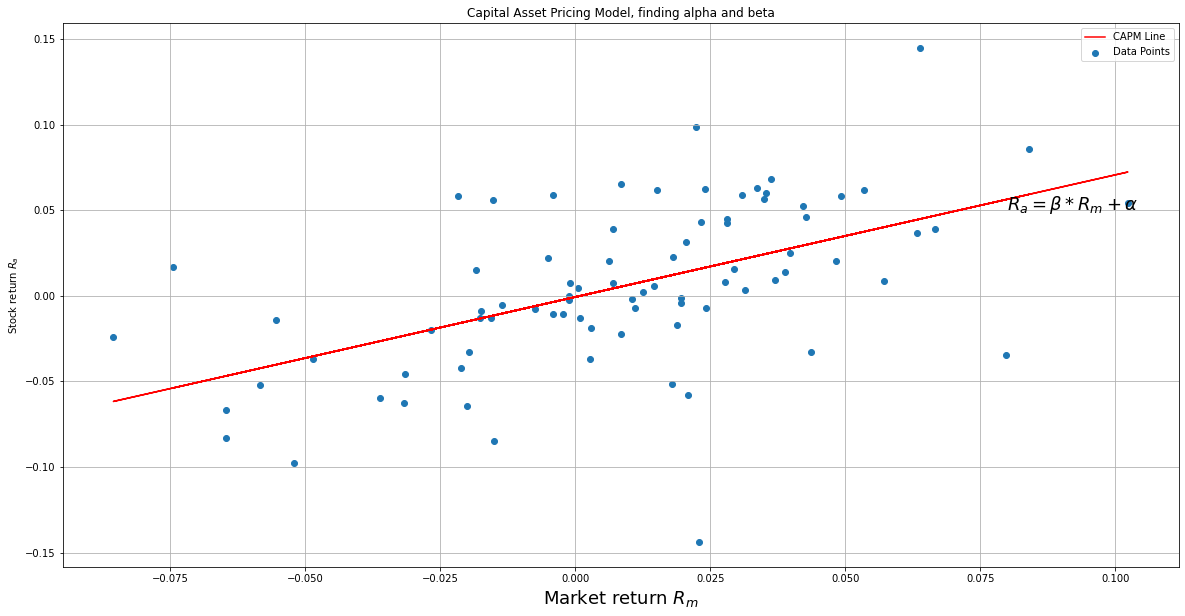

In [14]:
fig, axis = plt.subplots(1, figsize=(20, 10))
axis.scatter(data["m_returns"], data['s_returns'],
             label="Data Points")
axis.plot(data["m_returns"], beta * data["m_returns"] + alpha,
          color='red', label="CAPM Line")
plt.title('Capital Asset Pricing Model, finding alpha and beta')
plt.xlabel('Market return $R_m$', fontsize=18)
plt.ylabel('Stock return $R_a$')
plt.text(0.08, 0.05, r'$R_a = \beta * R_m + \alpha$', fontsize=18)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# quão arriscada sua carteira em relação ao mercado
# beta < 1: o risco do mercado de ações é menor do que o de uma ação média
# menos arriscado que o mercado - retorna menos dinheiro
# beta deve ser > 1
# como não é arriscado, o retorno será menor

# se investir dinheiro na IBM, o retorno anual é de 9%
# beta < 1 - não é um investimento arriscado, mas podemos obter 9% de lucro